In [14]:
import numpy as np
import pandas as pd
import os
import sys as sys
import lightgbm as lgb
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.model_selection import train_test_split

In [2]:
path = '工程机械寿命预测选手/工程机械寿命预测选手/train/'

In [3]:
def compute_loss(target, predict):
    temp = np.square(np.log(abs(target + 1)) - np.log(abs(predict + 1)))
    res = np.sqrt(np.sum(temp) / len(temp))
    return res

In [4]:
def get_dir():
    file_names = os.listdir(path)
    return file_names

In [5]:
def get_types():
    component_types = []
    file_names = get_dir()
    for name in file_names:
        local_path = path+name
        temp = pd.read_csv(local_path,usecols=[13],nrows=1).iloc[0,0]
        component_types.append([temp,name])
    return component_types

In [5]:
# 训练集
# component_types = get_types()
# df_temp = pd.DataFrame(component_types)
# df_temp.groupby(by=0).size()
print('''0
S100    140
S26a    542
S508     10
S51d    188
Saa3     36
dtype: int64''')

0
S100    140
S26a    542
S508     10
S51d    188
Saa3     36
dtype: int64


In [6]:
# 测试集
# component_types = get_types()
# df_temp = pd.DataFrame(component_types)
# df_temp.groupby(by=0).size()
print('''0
S100    148
S26a    499
S508     12
S51d    179
Saa3     51
dtype: int64''')

0
S100    148
S26a    499
S508     12
S51d    179
Saa3     51
dtype: int64


In [6]:
# component_types = get_types()
# df = pd.DataFrame(component_types)
# df.to_excel('data/df.xlsx',index=False)
df = pd.read_excel('data/df.xlsx')

In [7]:
def read_csv(component_types='S26a',row=0):
    name = df.set_index(0).loc[component_types,:].iloc[row,0]
    local_path = path+name
    df_temp = pd.read_csv(local_path,encoding='utf-8')
    df_temp.drop(['设备类型'],axis=1,inplace=True)
    df_temp['机械序号'] = row
    return df_temp

In [8]:
def pre_processing(df_0):
    df_0 = df_0[df_0['部件工作时长']>=0] # 除掉工作时长小于0的噪音点
    df_0['剩余寿命'] = df_0['部件工作时长'].iloc[len(df_0['部件工作时长'])-1] - df_0['部件工作时长']
    df_0 = df_0[df_0['剩余寿命']>=0] # 除掉剩余寿命小于0的噪音点
    return df_0

In [9]:
# def concat_df(component_types = 'S100'):
component_types='S100'
df_all = pd.DataFrame()
for row,name in enumerate(df.set_index(0).loc[component_types,:][1]):
    local_path = path+name
    df_temp = pd.read_csv(local_path)
    df_temp.drop(['设备类型'],axis=1,inplace=True)
    df_temp['机械序号'] = row
    print(row,end=' ')
    df_temp = pre_processing(df_temp)
    df_temp = df_temp.astype('float32')
    df_all = pd.concat([df_all,df_temp])
#     return df_all

0 1 2 3 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 

## 建立模型

In [10]:
X_train,X_valid,y_train,y_valid = train_test_split(df_all.drop(['剩余寿命'],axis=1),
                                                   df_all['剩余寿命'],test_size=1/10,random_state =2000)

In [17]:
def weighted_lgb(labels,preds): 
    return 'weighted',-compute_loss(labels,preds),True

In [142]:
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        max_depth=15,
                        learning_rate=0.10,
                        n_estimators=15000,)
gbm.fit(X_train.drop(['部件工作时长','机械序号'],axis=1), y_train,
        eval_set=[(X_valid.drop(['部件工作时长','机械序号'],axis=1), y_valid)],
        eval_metric='l1',
        early_stopping_rounds=15,verbose=15)

Training until validation scores don't improve for 15 rounds.
[15]	valid_0's l1: 430.051	valid_0's l2: 359164
[30]	valid_0's l1: 301.97	valid_0's l2: 230708
[45]	valid_0's l1: 253.429	valid_0's l2: 179828
[60]	valid_0's l1: 231.421	valid_0's l2: 152597
[75]	valid_0's l1: 215.23	valid_0's l2: 136362
[90]	valid_0's l1: 200.031	valid_0's l2: 119692
[105]	valid_0's l1: 187.476	valid_0's l2: 108708
[120]	valid_0's l1: 181.842	valid_0's l2: 103668
[135]	valid_0's l1: 175.625	valid_0's l2: 98732.9
[150]	valid_0's l1: 169.385	valid_0's l2: 93000.4
[165]	valid_0's l1: 164.491	valid_0's l2: 87713.7
[180]	valid_0's l1: 160.276	valid_0's l2: 84332.2
[195]	valid_0's l1: 155.556	valid_0's l2: 80432.1
[210]	valid_0's l1: 152.598	valid_0's l2: 77652.2
[225]	valid_0's l1: 149.82	valid_0's l2: 75309.6
[240]	valid_0's l1: 146.876	valid_0's l2: 72847.8
[255]	valid_0's l1: 143.58	valid_0's l2: 70013.3
[270]	valid_0's l1: 140.579	valid_0's l2: 67729.7
[285]	valid_0's l1: 138.606	valid_0's l2: 66119.9
[300]	

[2505]	valid_0's l1: 71.5407	valid_0's l2: 24477.6
[2520]	valid_0's l1: 71.5	valid_0's l2: 24471.2
[2535]	valid_0's l1: 71.4029	valid_0's l2: 24428.2
[2550]	valid_0's l1: 71.3175	valid_0's l2: 24408.8
[2565]	valid_0's l1: 71.2623	valid_0's l2: 24395.1
[2580]	valid_0's l1: 71.1889	valid_0's l2: 24382.5
[2595]	valid_0's l1: 71.1065	valid_0's l2: 24356.4
[2610]	valid_0's l1: 71.0691	valid_0's l2: 24342.9
[2625]	valid_0's l1: 71.0209	valid_0's l2: 24321.2
[2640]	valid_0's l1: 70.9484	valid_0's l2: 24294.2
[2655]	valid_0's l1: 70.8956	valid_0's l2: 24257.5
[2670]	valid_0's l1: 70.82	valid_0's l2: 24225.8
[2685]	valid_0's l1: 70.7612	valid_0's l2: 24205.8
[2700]	valid_0's l1: 70.7197	valid_0's l2: 24193
[2715]	valid_0's l1: 70.6743	valid_0's l2: 24179.1
[2730]	valid_0's l1: 70.5749	valid_0's l2: 24147.4
[2745]	valid_0's l1: 70.4775	valid_0's l2: 24084.3
[2760]	valid_0's l1: 70.374	valid_0's l2: 24057.8
[2775]	valid_0's l1: 70.3012	valid_0's l2: 24046.5
[2790]	valid_0's l1: 70.2428	valid_0's 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=15,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=15000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [143]:
compute_loss(gbm.predict(X_valid.drop(['部件工作时长','机械序号'],axis=1)),y_valid)

0.48646578281039765

In [11]:
def load_model(model_name='gbm_S100'):
    local_path = 'model/'+model_name+'.pkl'
    local_gbm = joblib.load(local_path)
    return local_gbm
def dump_model(model,model_name='gbm_S100'):
    local_path = 'model/'+model_name+'.pkl'
    joblib.dump(model,local_path)

In [144]:
dump_model(model=gbm,model_name='gbm_S508')

In [12]:
gbm = load_model()

In [25]:
ax1.bar?

平均值：
5592.341881179731
中位数：
5502.292025184885
真实值：
5515.5


<IPython.core.display.Javascript object>


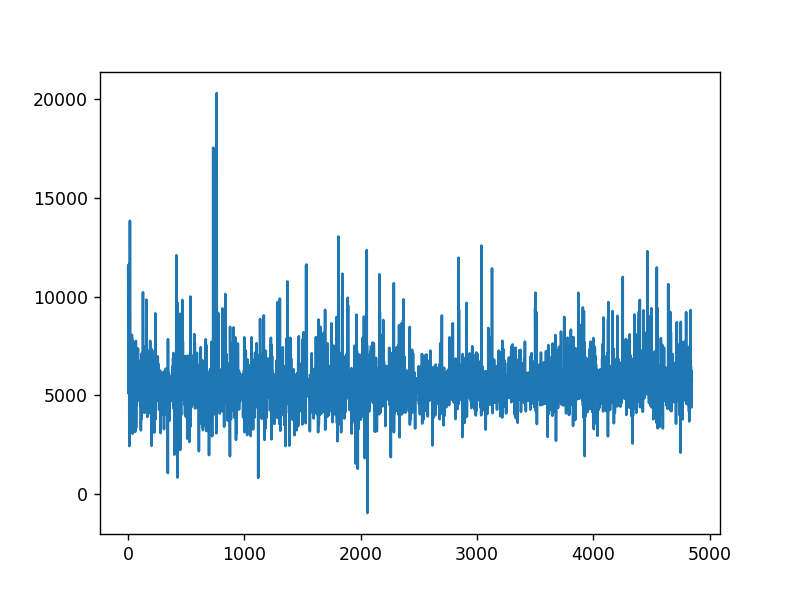

In [32]:
i = 3
df_temp = X_valid.set_index('机械序号').loc[i].sort_values(by='累积量参数1')
temp = gbm.predict(df_temp.drop(['部件工作时长'],axis=1)) + df_temp['部件工作时长']
print('平均值：')
print(temp.mean())
print('中位数：')
print(temp.median())
print('真实值：')
print(read_csv(component_types='S100',row=i).iloc[-1,0])
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)  
ax1.plot(range(0,len(temp)),temp)

平均值：
5120.102064970413
中位数：
5075.20348258436
真实值：
5075.999999999999


<IPython.core.display.Javascript object>


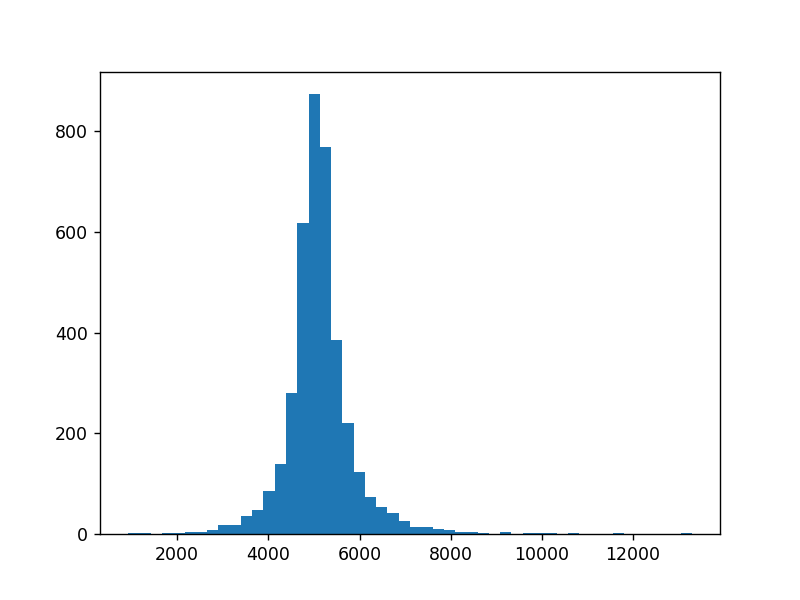

lucky


In [15]:
i = 1
df_temp = X_valid.set_index('机械序号').loc[i].sort_values(by='累积量参数1')
temp = gbm.predict(df_temp.drop(['部件工作时长'],axis=1)) + df_temp['部件工作时长']
print('平均值：')
print(temp.mean())
print('中位数：')
print(temp.median())
print('真实值：')
print(read_csv(component_types='S100',row=i).iloc[-1,0])
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)  
ax1.hist(temp,bins=50)
print('lucky')

## 预测测试集

In [3]:
path = '工程机械寿命预测选手/工程机械寿命预测选手/test1//'

In [5]:
# component_types = get_types()
# df_test = pd.DataFrame(component_types)
# df_test.to_excel('data/df_test.xlsx',index=False)
df_test = pd.read_excel('data/df_test.xlsx')

In [7]:
def read_csv(component_types='S26a',row=0):
    name = df_test.set_index(0).loc[component_types,:].iloc[row,0]
    local_path = path+name
    df_temp = pd.read_csv(local_path)
    df_temp.drop(['设备类型'],axis=1,inplace=True)
    return df_temp,name

In [8]:
def pre_processing_test(df_0):
    df_0 = df_0[df_0['部件工作时长']>=0] # 除掉工作时长小于0的噪音点
    return df_0

In [9]:
print('''0
S100    148
S26a    499
S508     12
S51d    179
Saa3     51
dtype: int64''')

0
S100    148
S26a    499
S508     12
S51d    179
Saa3     51
dtype: int64


In [45]:
def predict(component_types):
    df_result = pd.DataFrame(columns=['test_file_name','life'])
    model_name = 'gbm_' + component_types
    gbm = load_model(model_name=model_name)
    for file_name in df_test.set_index(0).loc[component_types,:][1]:
        local_path = path+file_name
        df_temp = pd.read_csv(local_path)
        df_temp.drop(['设备类型'],axis=1,inplace=True)
        df_temp = pre_processing_test(df_temp)
        temp = gbm.predict(df_temp.drop(['部件工作时长'],axis=1))+df_temp['部件工作时长']
        total = temp.median()
#         rest = total - df_temp.iloc[-1,0]
        dct = {'test_file_name':[file_name],'life':[total]}
        df_result = pd.concat([df_result,pd.DataFrame(dct)])
    return df_result

In [46]:
component_types_list = ['S100','S26a','S508','S51d','Saa3']
for component_types in component_types_list:
    local_path = 'data/df_result_'+component_types+'total.csv'
    df_result_total = predict(component_types=component_types)
    df_result_total.to_csv(local_path,index=False)

In [50]:
def merge():
    df_result = pd.DataFrame(columns=['test_file_name','life'])
    component_types_list = ['S100','S26a','S508','S51d','Saa3']
    for component_types in component_types_list:
        local_path = 'data/df_result_'+component_types+'total.csv'
        df_temp = pd.read_csv(local_path)
        df_result = pd.concat([df_result,df_temp])
    return df_result

In [51]:
df_result = merge()

In [54]:
df_result.life[df_result.life<0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
df_result

,test_file_name,life
0,0120bc1afed1186f5b79.csv,2408.449134
1,02cf0f73d0eca3a1de31.csv,6300.447424
2,0337de7d2c1fcf58ae0f.csv,2417.511526
3,0422b1095cc935bd0d00.csv,3719.673435
4,05432877894ab7e05529.csv,4475.986431
5,0907ef0c2cc934c85d99.csv,1513.642198
6,09cf7e03174f61841158.csv,5512.822891
7,09dac7a0ca857525965b.csv,9438.133075
8,0c1def9f76ea1de5b614.csv,2819.303757
9,103ee18ed94f7687cf67.csv,2309.512691


In [56]:
df_result.to_csv('data/df_result_total.csv',index=False)

平均值：
2958.474428355738
中位数：
2417.5115259019303
尾数值：
1291.2500000000002


<IPython.core.display.Javascript object>


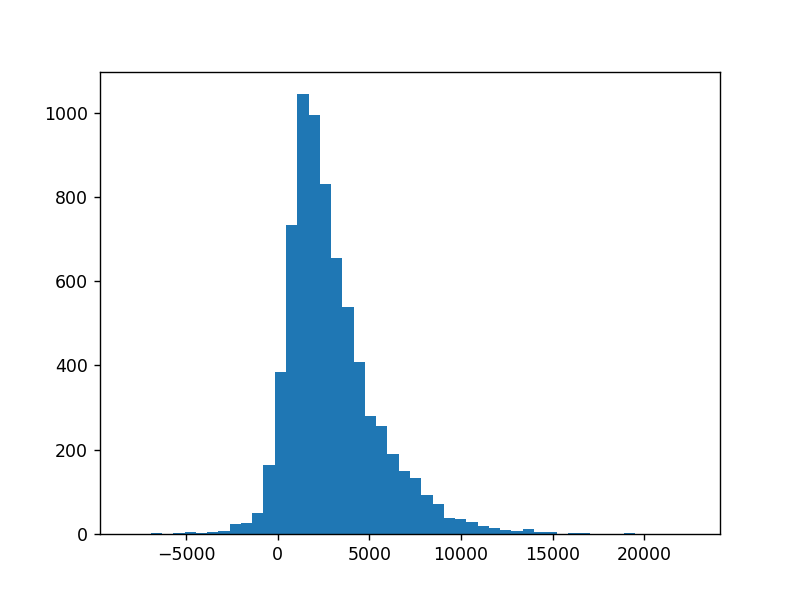

lucky


In [203]:
i = 2
df_test_0 = read_csv(component_types='S100',row=i)
df_test_0 = pre_processing_test(df_test_0)
temp = gbm.predict(df_test_0.drop(['部件工作时长'],axis=1))+df_test_0['部件工作时长']
print('平均值：')
print(temp.mean())
print('中位数：')
print(temp.median())
print('尾数值：')
print(read_csv(component_types='S100',row=i).iloc[-1,0])
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)  
ax1.hist(temp,bins=50)
print('lucky')